### Preamble

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/python/BayesianFiltering

/content/drive/MyDrive/python/BayesianFiltering


In [4]:
from codebase.utils import split_to_sigma_points
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd

### Definitions and MC approx

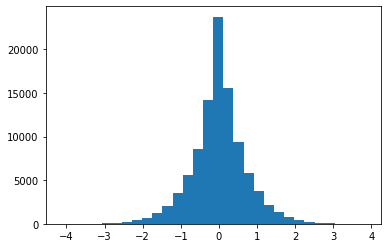

MC approx to mean of Y: -0.0029406719388111735
MC approx to var of Y: 0.49748695243035246
MC approx to cov of X and Y: [-0.00658385  0.00322084]


In [51]:
dx = 2
#m = np.random.multivariate_normal(np.zeros(dx), 1*np.eye(dx)) # np.array([1]+[0]*(dx-1))
m = np.zeros(dx)
eig = np.array(range(1,dx+1))
P = np.diag(eig)
Q = 0.1
dy = 1
N = 100000

# Definition of non-linearity
## 1
# p = 3
# f = lambda x: (1 + np.dot(x,x))**(p/2)
# J = lambda x : p* (1 + np.dot(x,x))**(p/2-1) * x
# H = lambda x : 2*p*(p/2-1)*(1 + np.dot(x,x))**(p/2-2)*np.outer(x,x) + np.eye(dx)*p* (1 + np.dot(x,x))**(p/2-1)

## 2
# f = lambda x: np.sin(np.dot(x,x))/np.dot(x,x)
# J = lambda x: 2 * (np.dot(x,x)*np.cos(np.dot(x,x)) - np.sin(np.dot(x,x))) / (np.dot(x,x))**2 * x
# H = lambda x: -4*(np.sin(np.dot(x,x))/np.dot(x,x) + \
#                   2*(np.cos(np.dot(x,x))*np.dot(x,x) - \
#                      np.sin(np.dot(x,x))) / np.dot(x,x)**3 ) * \
#                      np.outer(x,x) + 2 * (np.dot(x,x)*np.cos(np.dot(x,x)) - \
#                                           np.sin(np.dot(x,x))) / \
#                                           (np.dot(x,x))**2 * np.eye(dx)

## 3 Linear-Nonlinear product
f = lambda x: x[0] * np.sin(x[1])
J = lambda x: np.array([np.sin(x[1]), x[0]*np.cos(x[1])])
H = lambda x: np.array([[0, np.cos(x[1])],[np.cos(x[1]), -x[0]*np.sin(x[1])]])

## 4 Linear-Nonlinear sum
# f = lambda x: x[0] + np.sin(x[1])
# J = lambda x: np.array([1, np.cos(x[1])])
# H = lambda x: np.array([[0,0],[0, -np.sin(x[1])]])

## 5 Quadratic
# a = 1
# b = 1
# A = np.array([[a, 0 ],[0, b]])
# f = lambda x: np.dot(x, np.matmul(A,x))/2
# J = lambda x: np.matmul(A,x)
# H = lambda x: A

# Simulation and visualization
if dx == 1:
  x = np.random.normal(m, P, size = N)
else:
  x = np.random.multivariate_normal(m, P, size = N)
y = np.array(list(map(f, x))) + np.random.normal(0, Q, N)

plt.hist(y, 30)
plt.show()


meanY_MC = np.mean(y)
varY_MC = np.var(y)
covXY_MC = np.matmul(np.transpose(x-m),y-np.mean(y))/(N-1)


print('MC approx to mean of Y:', meanY_MC)
print('MC approx to var of Y:', varY_MC)
print('MC approx to cov of X and Y:', covXY_MC)

In [64]:
P

array([[1, 0],
       [0, 2]])

###Simple Linerization

In [52]:
meanY_L = f(m)
if dx == 1:
  varY_L = Q + J(m) * P *J(m)
  covXY_L = P * J(m)
else:
  varY_L = Q + np.dot(J(m), np.matmul(P,J(m)))
  covXY_L = np.matmul(P, J(m))

### Unscented Transform

In [53]:
lam = 1
alpha = 1
beta = 1
sigma_points = split_to_sigma_points(m, P, lam)
Y_sigma_points = np.array(list(map(f, sigma_points)))

meanY_U = (lam / (dx+lam))*Y_sigma_points[0] + 1 / (2*(dx+lam)) * sum(Y_sigma_points[1:])
varY_U = Q + (lam/(dx+lam) + 1 - alpha**2 + beta) * (Y_sigma_points[0]-meanY_U)**2 + \
                           1/(2*(dx+lam)) * sum((Y_sigma_points[1:]-meanY_U)**2)

covXY_U = (lam/(dx+lam) + 1 - alpha**2 + beta)*(Y_sigma_points[0]-meanY_U)*(sigma_points[0] - m) + \
                           1/(2*(dx+lam))* np.matmul((Y_sigma_points[1:]-meanY_U), (sigma_points[1:] - m))

### Augmented Linearization

In [60]:
# Hessian at m
print(m)
print('Hessian eigen', np.linalg.eig(H(m)))
vals ,vecs = np.linalg.eig(H(m))

[0. 0.]
Hessian eigen (array([ 1., -1.]), array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]]))


In [55]:
np.trace(np.matmul(H(m),np.matmul(np.matmul(vecs, np.array([[0.19017882, 0],[0, -3.26516065]])),np.transpose(vecs))))

3.4553394699999993

#### m=1

In [74]:
mz = np.array([0])
Nz = 1000


Nsim = 100
ev1 = 1
ev2 = 1
meanError = np.zeros(Nsim)
minEig = np.zeros(Nsim)
for i in range(Nsim):
  ev1 = 10*0.1*0.98 #5
  ev2 = 0.015*67*0.98 #58
  Delta = np.matmul(np.matmul(vecs, np.array([[ev1, 0],[0, ev2]])),np.transpose(vecs))

  evals, evecs = np.linalg.eig(P-Delta)
  maxloc = np.argmax(evals)
  Pz = evals[maxloc]
  Gamma = evecs[maxloc]


  # MC approx of z-integral
  if Pz<0: 
    print('Error, negative variance at i=',i)
    break
  z = np.random.normal(mz, Pz, Nz)
  x_tilde = np.outer(z, Gamma) + m
  y_tilde = np.array(list(map(f, x_tilde)))
  meanY_AL = np.mean(y_tilde)
  gradients = np.array(list(map(J, x_tilde)))
  varY_AL = Q + sum((y_tilde-meanY_AL)**2)/Nz + np.trace(np.matmul(np.matmul(gradients, Delta), np.transpose(gradients)))/Nz
  covXY_AL = np.matmul(Delta, np.mean(gradients, axis =0)) + np.matmul(np.transpose(x_tilde - m), y_tilde - meanY_AL) / Nz

  # Quadrature approx of z-integral
  # z = split_to_sigma_points(mz, Pz, lam)
  # x_tilde = np.outer(z, Gamma) + m
  # y_tilde = np.array(list(map(f, x_tilde)))
  # gradients = np.array(list(map(J, x_tilde)))
  # w0m = lam/(dx+lam)
  # wim = 1/(2*(dx+lam))
  # w0c =  ( lam / (dx + lam) + 1 - alpha**2 + beta)
  # wic = wim

  # meanY_AL = w0m*y_tilde[0] + wim*sum(y_tilde[1:])


  # varY_AL = Q + w0c * (y_tilde[0]-meanY_AL)**2 + wic *sum((y_tilde[1:]-meanY_AL)**2) + \
  #               w0c * np.matmul(np.matmul(gradients[0], Delta), np.transpose(gradients[0])) + \
  #               wic * np.trace(np.matmul(np.matmul(gradients[1:], Delta), np.transpose(gradients[1:])))

  # covXY_AL = w0c * (y_tilde[0]-meanY_U)*(x_tilde[0] - m) +  wic * np.matmul((y_tilde[1:]-meanY_U), (x_tilde[1:] - m)) + \
  #           w0c * np.matmul(Delta, gradients[0]) + wic * np.matmul(Delta, np.mean(gradients[1:], axis =0))


  meanError[i] = abs(meanY_AL - meanY_MC)
  minEig[i] = np.min(evals)

70
[ 0.30992858  0.30770322  0.30543763  0.3031309   0.30078211  0.29839034
  0.29595462  0.29347399  0.29094744  0.28837397  0.28575255  0.28308211
  0.28036159  0.27758989  0.2747659   0.2718885   0.26895653  0.26596882
  0.2629242   0.25982144  0.25665934  0.25343665  0.25015212  0.24680448
  0.24339244  0.23991472  0.23636999  0.23275694  0.22907424  0.22532054
  0.2214945   0.21759476  0.21361996  0.20956874  0.20543973  0.20123158
  0.19694293  0.19257241  0.18811868  0.1835804   0.17895624  0.17424489
  0.16944505  0.16455544  0.1595748   0.15450191  0.14933554  0.14407454
  0.13871775  0.13326407  0.12771242  0.12206178  0.11631115  0.11045961
  0.10450624  0.09845022  0.09229076  0.08602713  0.07965864  0.0731847
  0.06660474  0.05991828  0.05312489  0.04622422  0.03921599  0.03209996
  0.02487599  0.017544    0.01010397  0.00255596 -0.00509989 -0.0128634
 -0.02073429 -0.02871223 -0.03679682 -0.04498759 -0.05328402 -0.06168551
 -0.0701914  -0.07880098 -0.08751349 -0.0963281  -

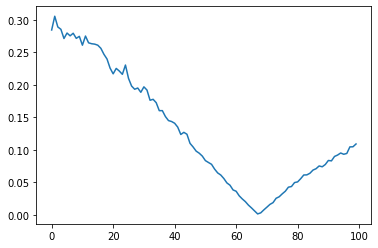

In [73]:
print(sum(minEig>0))
print(minEig)
print(meanError)
print(np.argmin(meanError))
plt.plot(meanError)
plt.show()

#### m=2

In [58]:
Nz = 100
Nsim = 50
ev1 = 1
ev2 = 1
meanError = np.zeros(Nsim)
minEig = np.zeros(Nsim)
for i in range(Nsim):
  ev1 = 0.01*i #5
  ev2 = 0.01*21*-3.26516065 #58
  Delta = np.matmul(np.matmul(vecs, np.array([[ev1, 0],[0, ev2]])),np.transpose(vecs))
  evals, evecs = np.linalg.eig(P-Delta)
  mz = m
  Pz = P-Delta

  # # # MC approx of z-integral
  # z = np.random.multivariate_normal(mz, Pz, Nz)
  # x_tilde = z
  # y_tilde = np.array(list(map(f, x_tilde)))
  # meanY_AL = np.mean(y_tilde)
  # gradients = np.array(list(map(J, x_tilde)))
  # varY_AL = Q + sum((y_tilde-meanY_AL)**2)/Nz + np.trace(np.matmul(np.matmul(gradients, Delta), np.transpose(gradients)))/Nz
  # covXY_AL = np.matmul(Delta, np.mean(gradients, axis =0)) + np.matmul(np.transpose(x_tilde - m), y_tilde - meanY_AL) / Nz

  # Quadrature approx of z-integral
  print(i)
  z = split_to_sigma_points(mz, Pz, lam)
  x_tilde = z
  y_tilde = np.array(list(map(f, x_tilde)))
  gradients = np.array(list(map(J, x_tilde)))
  w0m = lam/(dx+lam)
  wim = 1/(2*(dx+lam))
  w0c =  ( lam / (dx + lam) + 1 - alpha**2 + beta)
  wic = wim

  meanY_AL = w0m*y_tilde[0] + wim*sum(y_tilde[1:])


  varY_AL = Q + w0c * (y_tilde[0]-meanY_AL)**2 + wic *sum((y_tilde[1:]-meanY_AL)**2) + \
                w0c * np.matmul(np.matmul(gradients[0], Delta), np.transpose(gradients[0])) + \
                wic * np.trace(np.matmul(np.matmul(gradients[1:], Delta), np.transpose(gradients[1:])))

  covXY_AL = w0c * (y_tilde[0]-meanY_U)*(x_tilde[0] - m) +  wic * np.matmul((y_tilde[1:]-meanY_U), (x_tilde[1:] - m)) + \
            w0c * np.matmul(Delta, gradients[0]) + wic * np.matmul(Delta, np.mean(gradients[1:], axis =0))

  meanError[i] = abs(meanY_AL - meanY_MC)
  minEig[i] = np.min(evals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


50
[1.46373188 1.44348894 1.42324539 1.40300122 1.38275645 1.36251107
 1.34226511 1.32201855 1.3017714  1.28152367 1.26127537 1.2410265
 1.22077706 1.20052706 1.1802765  1.16002539 1.13977373 1.11952153
 1.09926879 1.07901552 1.05876172 1.03850739 1.01825254 0.99799718
 0.9777413  0.95748492 0.93722803 0.91697064 0.89671275 0.87645437
 0.85619551 0.83593616 0.81567633 0.79541602 0.77515524 0.75489399
 0.73463228 0.7143701  0.69410747 0.67384438 0.65358084 0.63331686
 0.61305243 0.59278756 0.57252225 0.55225651 0.53199034 0.51172374
 0.49145672 0.47118928]
[0.37897817 0.36511386 0.35119481 0.3372226  0.32319887 0.30912526
 0.29500347 0.28083519 0.26662215 0.25236612 0.23806887 0.22373221
 0.20935799 0.19494806 0.18050431 0.16602866 0.15152305 0.13698945
 0.12242986 0.1078463  0.09324083 0.07861551 0.06397246 0.04931381
 0.03464171 0.01995836 0.00526597 0.00943321 0.02413693 0.03884287
 0.05354873 0.06825213 0.08295071 0.09764206 0.11232374 0.12699329
 0.14164822 0.15628602 0.17090414 0.

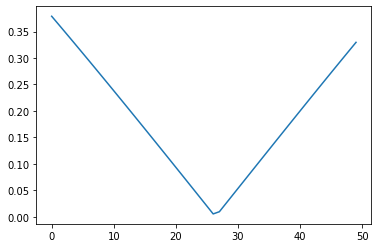

In [59]:
print(sum(minEig>0))
print(minEig)
print(meanError)
print(np.argmin(meanError))
plt.plot(meanError)
plt.show()

### Results

In [75]:
df = pd.DataFrame(columns = [' ','MC','L','U','AL'])
df[' '] = ['meanY', 'errMean', 'varY', 'errVar', 'covXY']
df['MC'] = [meanY_MC, 0, varY_MC, 0, covXY_MC]
df['L'] = [meanY_L, abs(meanY_L-meanY_MC), varY_L, abs(varY_L - varY_MC), covXY_L]
df['U'] = [meanY_U, abs(meanY_U-meanY_MC),varY_U, abs(varY_U - varY_MC),covXY_U]
df['AL'] = [meanY_AL, abs(meanY_AL-meanY_MC),varY_AL, abs(varY_AL - varY_MC),covXY_AL]
df
# print('-----------Errors of Unscented Approximation----------------')
# print('Error for mean of Y', (meanY_U-meanY_MC)**2 )
# print('Error for var of Y', (varY_U-varY_MC)**2 )
# print('Error for cov of X and Y', np.dot(covXY_MC - covXY_U, covXY_MC - covXY_U))
# print('----------Errors of Augmented Linear Approximation---------')
# print('Error for mean of Y', (meanY_AL-meanY_MC)**2 )
# print('Error for var of Y', (varY_AL-varY_MC)**2 )
# print('Error for cov of X and Y', np.dot(covXY_MC - covXY_AL,covXY_MC - covXY_AL))

,,MC,L,U,AL
0,meanY,-0.002941,0.0,0.0,-0.001526
1,errMean,0,0.002941,0.002941,0.001415
2,varY,0.497487,0.1,0.1,0.53893
3,errVar,0,0.397487,0.397487,0.041443
4,covXY,"[-0.006583853505047984, 0.003220843435433373]","[0.0, 0.0]","[0.0, 0.0]","[-0.013207427158593545, 6.191291132855487e-05]"
